In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3,3), dtype=int)
        self.current_player = 1

    def reset(self):
        self.board[:] = 0
        self.current_player = 1
        return self.get_state()

    def get_state(self):
        return tuple(self.board.flatten())

    def legal_actions(self):
        return [(i,j) for i in range(3) for j in range(3)
                if self.board[i,j] == 0]

    def play(self, action):
        i,j = action
        self.board[i,j] = self.current_player
        self.current_player *= -1

    def winner(self):
        lines = []
        lines.extend(self.board)
        lines.extend(self.board.T)
        lines.append(np.diag(self.board))
        lines.append(np.diag(np.fliplr(self.board)))

        for line in lines:
            if np.all(line == 1): return 1
            if np.all(line == -1): return -1
        return None

    def terminal(self):
        return self.winner() is not None or not self.legal_actions()

In [3]:
class RLAgent:
    def __init__(self, alpha=0.1, epsilon=0.1):
        self.V = defaultdict(lambda: 0.5)
        self.alpha = alpha
        self.epsilon = epsilon

    def choose_action(self, env):
        actions = env.legal_actions()

        if random.random() < self.epsilon:
            return random.choice(actions)

        best_val = -1e9
        best_action = None

        for a in actions:
            temp = TicTacToe()
            temp.board = env.board.copy()
            temp.current_player = env.current_player
            temp.play(a)
            v = self.V[temp.get_state()]

            if v > best_val:
                best_val = v
                best_action = a

        return best_action

    def update(self, s, s_next):
        self.V[s] += self.alpha * (self.V[s_next] - self.V[s])

In [4]:
def reward(winner):
    if winner == 1:
        return 1
    elif winner == -1:
        return -1
    else:
        return 0

In [5]:
def train(agent, episodes=40000):
    env = TicTacToe()

    wins, losses, draws = [], [], []
    w = l = d = 0

    for ep in range(episodes):
        s = env.reset()
        trajectory = []

        while not env.terminal():
            a = agent.choose_action(env)
            env.play(a)
            s_next = env.get_state()
            trajectory.append((s, s_next))
            s = s_next

        r = reward(env.winner())
        agent.V[s] = r

        for s, s_next in reversed(trajectory):
            agent.update(s, s_next)

        if r == 1: w += 1
        elif r == -1: l += 1
        else: d += 1

        wins.append(w/(ep+1))
        losses.append(l/(ep+1))
        draws.append(d/(ep+1))

    return agent, wins, losses, draws

In [6]:
greedy_agent = RLAgent(epsilon=0.0)
eps_agent = RLAgent(epsilon=0.1)

greedy_agent, gw, gl, gd = train(greedy_agent)
eps_agent, ew, el, ed = train(eps_agent)

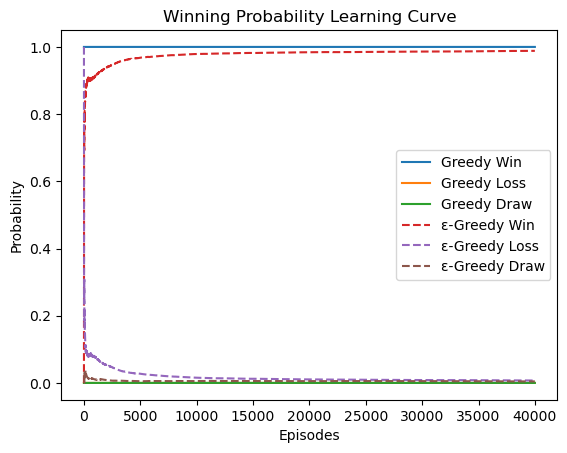

In [7]:
plt.figure()
plt.plot(gw, label="Greedy Win")
plt.plot(gl, label="Greedy Loss")
plt.plot(gd, label="Greedy Draw")

plt.plot(ew, '--', label="ε-Greedy Win")
plt.plot(el, '--', label="ε-Greedy Loss")
plt.plot(ed, '--', label="ε-Greedy Draw")

plt.xlabel("Episodes")
plt.ylabel("Probability")
plt.title("Winning Probability Learning Curve")
plt.legend()
plt.show()

In [8]:
def final_trajectory(agent):
    env = TicTacToe()
    env.reset()
    agent.epsilon = 0

    traj = []

    while not env.terminal():
        state = env.get_state()
        action = agent.choose_action(env)
        traj.append((state, action))
        env.play(action)

    return traj, env.winner()

In [9]:
def print_trajectory(traj, winner):
    sym = {1:"X", -1:"O", 0:"."}

    for t,(s,a) in enumerate(traj):
        print(f"\nStep {t+1}, Action {a}")
        board = np.array(s).reshape(3,3)
        for r in board:
            print(" ".join(sym[x] for x in r))

    print("\nFinal Outcome:", "Draw" if winner==0 else "Win/Loss")

In [10]:
traj, winner = final_trajectory(eps_agent)
print_trajectory(traj, winner)


Step 1, Action (0, 1)
. . .
. . .
. . .

Step 2, Action (0, 0)
. X .
. . .
. . .

Step 3, Action (2, 1)
O X .
. . .
. . .

Step 4, Action (1, 2)
O X .
. . .
. X .

Step 5, Action (1, 1)
O X .
. . O
. X .

Final Outcome: Win/Loss
